# Variational Quantum Eigensolver (VQE) for HeH+

This notebook involves my code implementation for the research paper titled which can be found on the link https://arxiv.org/pdf/1304.3061. This is my final project as a part of the SoC-2024.

In [30]:
#importing the required libraries
import pennylane as qml
from pennylane import numpy as np
import jax
import optax
import matplotlib.pyplot as plt
from pennylane import qchem

## Loading the Hamiltonian
Here, the hamiltonian for the HeH+ molecule has been uploaded using pennylane. The nuclear coordinates have been obtained from wikipedia. 
Source:https://en.wikipedia.org/wiki/Helium_hydride_ion#:~:text=The%20length%20of%20the%20covalent,0.772%20%C3%85%20or%2077.2%20pm.
Then by using the molecular_hamiltonian function, the Hamiltonian and the qubits are obtained.

In [31]:
#Defining the molecule
symbols = ["He", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],[0.0, 0.0, 0.772]])
#Generating the molecular hamiltonian
H, qubits = qchem.molecular_hamiltonian(symbols, coordinates,charge=1, basis='sto-3g')


In [88]:
#Setting up the quantum device
dev = qml.device('default.qubit', wires=qubits)
electrons = 2
hf = qchem.hf_state(electrons, qubits)
print("Hartree-Fock state:", hf)

Hartree-Fock state: [1 1 0 0]


# Defining the Quantum Circuit
The quantum circuit has been defined with increased number of parameters i.e. 4 to make it more expressive and for better accuracy.

In [93]:
@qml.qnode(dev)
def circuit(params, wires):
    qml.BasisState(hf, wires=range(qubits))
    qml.DoubleExcitation(params[0], wires=[0,1,2,3])
    qml.DoubleExcitation(params[1], wires=[0,1,2,3])
    qml.SingleExcitation(params[2], wires=[0,2])
    qml.SingleExcitation(params[3], wires=[1,3])
    return qml.expval(H)

In [103]:
#Defining the cost function
def cost_fn(params):
    return circuit(params, wires=range(qubits))

# Classical Optimization
A classical optimizer was used to find the optimal parameters for the quantum circuit. The optimizer adjusted the parameters to minimize the cost function, which eventually gives the ground-state energy of the molecule.

In [99]:
# Setting optimization parameters
max_iterations = 500
conv_tol = 1e-06
opt = optax.adam(learning_rate=0.1)

In [104]:
# Initializing parameters and running optimization
theta = np.random.random(4)
# Storing values of the cost function
energy = [cost_fn(theta)]
#Storing the values of the circuit parameter
angles = [theta]
opt_state = opt.init(theta)

In [105]:
# Running the optimization loop
for n in range(max_iterations):
    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angles.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 100 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\nFinal value of the ground-state energy = {:.8f} Ha".format(energy[-1]))
print("Optimal value of the circuit parameter = {:.4f}".format(angles[-1][0]))

e:\Quantum Computing SoC\venv\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Step = 0,  Energy = -1.88716447 Ha


e:\Quantum Computing SoC\venv\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
e:\Quantum Computing SoC\venv\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
e:\Quantum Computing SoC\venv\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
e:\Quantum Computing SoC\venv\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, a


Final value of the ground-state energy = -2.40362620 Ha
Optimal value of the circuit parameter = -0.3675


e:\Quantum Computing SoC\venv\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


# Results
Finally, the plot for the results of optimization was plotted using the code cell below, showing the convergence of the energy and the optimal circuit parameters.

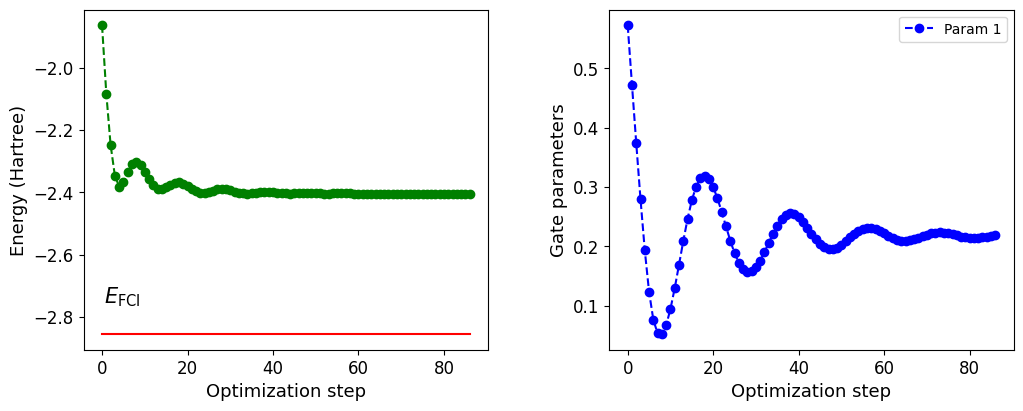

In [102]:
# Plot the results
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)
E_fci = -2.8551605

# Adding energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(energy)), energy, "go", ls="dashed")
ax1.plot(range(len(energy)), np.full(len(energy), E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, E_fci + 0.1, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding angle plot on column 2

ax2 = fig.add_subplot(122)
ax2.plot(range(len(angles)), [angle[0] for angle in angles], "bo", ls="dashed", label="Param 1")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameters", fontsize=13)
ax2.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()


## Explanation of Results

The results of our Variational Quantum Eigensolver (VQE) implementation are depicted in the following plots. Here's a detailed explanation of these results:

1. **Energy Convergence Plot:**
   - The left plot shows the convergence of the energy during the optimization process.
   - The y-axis represents the energy in Hartree units, and the x-axis represents the optimization steps.
   - The green dashed line represents the energy calculated at each step, while the red line indicates the reference Full Configuration Interaction (FCI) energy for comparison.

2. **Parameter Evolution Plot:**
   - The right plot shows the evolution of the circuit parameters during the optimization process.
   - The y-axis represents the values of the variational parameters, and the x-axis represents the optimization steps.
   - The blue dashed line represents the change in the first parameter, providing insight into how the optimization algorithm adjusts the circuit to minimize the energy.
   - The convergence of these parameters indicates that the optimization process successfully finds the optimal values for the quantum circuit, leading to the ground state energy.

The convergence of both the energy and the variational parameters demonstrates the reliability and accuracy of this hybrid quantum-classical approach.